<h1>Forecasting Test 1<h1>

<h4>Data Cleaning<h4>

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import cross_val_score
from joblib import Parallel, delayed
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

df = pd.read_csv('.\Datasets\CR_COST_FC.csv', converters={'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})
df['POD'] = pd.to_datetime(df['POD'])
df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
df = df.dropna(subset=['ENCODED_TYPE'])
df['RATE'] = df['RATE'].fillna(-1).astype(int)
df = df.dropna(subset=['RATE'])
df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)

# Remove NAN values
df_clean= df.dropna().reset_index(drop=True)

df_clean.head()
df_clean.info()
print(f'Dataset size: {df_clean.shape}')

,COM_ID,PARTY_ID,PARTY_ID_EN,PARTY_NAME,CSL_ID,ETA_ETD_NO,ETD_POL_D,POD_ID,POD,CNTR_ID,CNTR_SIZE,CNTR_TYPE,COST_TERM,RATE,ENCODED_TYPE,ENCODED_TERM,POD_ID_EN
0,010,010003678,10003678,OY TAVATUR SHIPPING LTD,ECS010060100191,20060228,FIHEL,HELSINKI,2006-02-28,CTNR010060201232,20,GP,FC,675,2,1,4.103561e+09
1,010,010004286,10004286,"GLOBELINK KOREA CO., LTD",ECS010060100465,20060303,KRPUS,BUSAN,2006-03-03,CTNR010060300014,40,HC,FC,390,1,1,2.904902e+09
2,010,01005136,1005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,ECS010060100321,20060227,NZAKL,AUCKLAND,2006-02-27,CTNR010060201198,40,HC NOR,FC,1615,4,1,2.397848e+09
3,010,01002775,1002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,ECS010060200201,20060306,AUADL,ADELAIDE,2006-03-06,CTNR010060300119,40,HC,FC,700,1,1,2.480737e+08
4,010,01001088,1001088,CARGO LINES S.A.-LE HAVRE,ECS010060200146,20060307,FRMRS,MARSEILLE,2006-03-07,CTNR010060300185,20,GP,FC,675,2,1,4.197227e+08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54083 entries, 0 to 54082
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   COM_ID        54083 non-null  object        
 1   PARTY_ID      54083 non-null  object        
 2   PARTY_ID_EN   54083 non-null  int64         
 3   PARTY_NAME    54083 non-null  object        
 4   CSL_ID        54083 non-null  object        
 5   ETA_ETD_NO    54083 non-null  int64         
 6   ETD_POL_D     54083 non-null  object        
 7   POD_ID        54083 non-null  object        
 8   POD           54083 non-null  datetime64[ns]
 9   CNTR_ID       54083 non-null  object        
 10  CNTR_SIZE     54083 non-null  object        
 11  CNTR_TYPE     54083 non-null  object        
 12  COST_TERM     54083 non-null  object        
 13  RATE          54083 non-null  int32         
 14  ENCODED_TYPE  54083 non-null  int32         
 15  ENCODED_TERM  54083 non-null  int64 

In [15]:
sel_col = ['CSL_ID', 'CNTR_ID','POD_ID','ETD_POL_D','PARTY_ID',
           'PARTY_NAME','POD','CNTR_SIZE','CNTR_TYPE','RATE']

df_fc = df_clean[sel_col]
df_fc.head()
df_fc.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010060100191,CTNR010060201232,HELSINKI,FIHEL,010003678,OY TAVATUR SHIPPING LTD,2006-02-28,20,GP,675
1,ECS010060100465,CTNR010060300014,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2006-03-03,40,HC,390
2,ECS010060100321,CTNR010060201198,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2006-02-27,40,HC NOR,1615
3,ECS010060200201,CTNR010060300119,ADELAIDE,AUADL,01002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,2006-03-06,40,HC,700
4,ECS010060200146,CTNR010060300185,MARSEILLE,FRMRS,01001088,CARGO LINES S.A.-LE HAVRE,2006-03-07,20,GP,675


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54083 entries, 0 to 54082
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      54083 non-null  object        
 1   CNTR_ID     54083 non-null  object        
 2   POD_ID      54083 non-null  object        
 3   ETD_POL_D   54083 non-null  object        
 4   PARTY_ID    54083 non-null  object        
 5   PARTY_NAME  54083 non-null  object        
 6   POD         54083 non-null  datetime64[ns]
 7   CNTR_SIZE   54083 non-null  object        
 8   CNTR_TYPE   54083 non-null  object        
 9   RATE        54083 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 3.9+ MB


In [16]:
# filter out rows where the year is 2002
df_filtered = df_fc[df_fc['POD'].dt.year != 2002]
df_filtered.head()
df_filtered.info()

# Checking if year 2002 is removed
df_filtered['POD'].dt.year.unique()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010060100191,CTNR010060201232,HELSINKI,FIHEL,010003678,OY TAVATUR SHIPPING LTD,2006-02-28,20,GP,675
1,ECS010060100465,CTNR010060300014,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2006-03-03,40,HC,390
2,ECS010060100321,CTNR010060201198,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2006-02-27,40,HC NOR,1615
3,ECS010060200201,CTNR010060300119,ADELAIDE,AUADL,01002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,2006-03-06,40,HC,700
4,ECS010060200146,CTNR010060300185,MARSEILLE,FRMRS,01001088,CARGO LINES S.A.-LE HAVRE,2006-03-07,20,GP,675


<class 'pandas.core.frame.DataFrame'>
Int64Index: 54082 entries, 0 to 54082
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      54082 non-null  object        
 1   CNTR_ID     54082 non-null  object        
 2   POD_ID      54082 non-null  object        
 3   ETD_POL_D   54082 non-null  object        
 4   PARTY_ID    54082 non-null  object        
 5   PARTY_NAME  54082 non-null  object        
 6   POD         54082 non-null  datetime64[ns]
 7   CNTR_SIZE   54082 non-null  object        
 8   CNTR_TYPE   54082 non-null  object        
 9   RATE        54082 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 4.3+ MB


array([2006, 2005, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2018, 2019, 2020, 2021, 2016, 2017, 2022, 2023], dtype=int64)

In [17]:
# Sorting the dates 
df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)
df_filtered.head()
df_filtered['POD'].dt.year.unique()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625


array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], dtype=int64)

<h4>FIltering and getting a list stored as a dictionary</h4>

In [18]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes

In [19]:
filtered_dataframes = filter_dataframe(df_filtered)

# Show case some samples of keys
df_ids = list(filtered_dataframes.keys())
print(list(df_ids))
print(len(list(df_ids)))

['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC N

<h4>Getting the top 5 ports</h4>

In [20]:
# Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
key_row_counts = {key: len(filtered_dataframes[key]) for key in filtered_dataframes}

# Sort the key_row_counts dictionary by value (number of rows) in descending order
sorted_key_row_counts = sorted(key_row_counts.items(), key=lambda item: item[1], reverse=True)
print(sorted_key_row_counts)

# Get the top 5 keys with the most rows
top_5_keys_tuple = sorted_key_row_counts[:5]
print(top_5_keys_tuple)

# Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
filtered_dataframes_subset = {}

for key, row_count in top_5_keys_tuple:
    filtered_dataframes_subset[key] = filtered_dataframes[key][:5]
    print(f"Number of rows in {key}: {row_count}")

print(filtered_dataframes_subset.keys())

[('Port_BUSAN_Size_40_Type_HC_PartyID_010004286', 1689), ('Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136', 1688), ('Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778', 1325), ('Port_SYDNEY_Size_40_Type_HC_PartyID_01002779', 1300), ('Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788', 1052), ('Port_HOCHIMINH CAT LAI,VIETNAM_Size_40_Type_HC_PartyID_010005256', 915), ('Port_AUCKLAND_Size_40_Type_HC NOR_PartyID_01005136', 865), ('Port_FREMANTLE_Size_40_Type_HC_PartyID_01002777', 814), ('Port_BRISBANE_Size_40_Type_HC_PartyID_01002776', 799), ('Port_MANILA (NORTH HARBOUR)_Size_40_Type_HC_PartyID_010021727', 672), ('Port_NHAVA SHEVA_Size_40_Type_HC_PartyID_01002787', 666), ('Port_PORT LOUIS_Size_40_Type_HC_PartyID_010007778', 650), ('Port_HAIPHONG_Size_40_Type_HC_PartyID_010005255', 646), ('Port_MADRAS/CHENNAI_Size_40_Type_HC_PartyID_010006979', 593), ('Port_FELIXSTOWE_Size_40_Type_HC_PartyID_01002303', 558), ('Port_VALPARAISO_Size_40_Type_HC NOR_PartyID_010006350', 556), ('Port_PIRAEUS_

In [21]:
# Selected dataframe
sel_df = filtered_dataframes['Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136']
sel_df.head()
sel_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600140,CTNR010050700496,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-19,40,HC,2200
1,ECS01050600140,CTNR010050700495,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-19,40,HC,2200
2,ECS010050700037,CTNR010050700657,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-21,40,HC,2300
3,ECS01050600141,CTNR010050700808,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-26,40,HC,2200
4,ECS01050600042,CTNR010050700971,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-29,40,HC,2600


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1688 entries, 0 to 1687
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1688 non-null   object        
 1   CNTR_ID     1688 non-null   object        
 2   POD_ID      1688 non-null   object        
 3   ETD_POL_D   1688 non-null   object        
 4   PARTY_ID    1688 non-null   object        
 5   PARTY_NAME  1688 non-null   object        
 6   POD         1688 non-null   datetime64[ns]
 7   CNTR_SIZE   1688 non-null   object        
 8   CNTR_TYPE   1688 non-null   object        
 9   RATE        1688 non-null   int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 138.5+ KB


In [30]:
# Determine how many bins for histogram using the Square Root Rule
num_bins = int(np.sqrt(len(sel_df)))
print(num_bins)


41


Text(0.5, 0, 'X-axis')

Text(0, 0.5, 'Y-axis')

Text(0.5, 1.0, 'Scatter Plot')

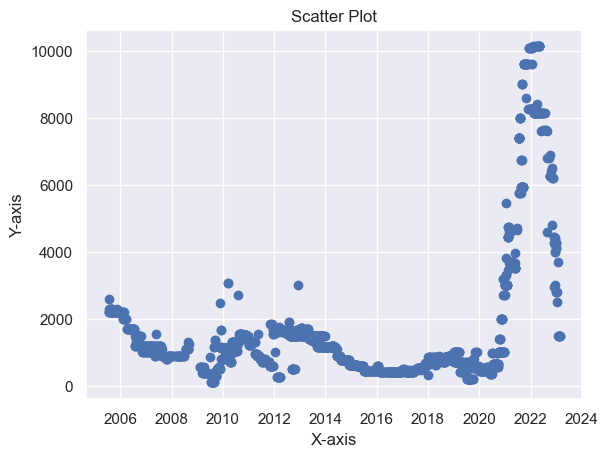

In [28]:
# Create scatter plot
plt.scatter(sel_df['POD'], sel_df['RATE'])

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot')

# Display the plot
plt.show()
